# Time-Series Search

This notebook demonstrates the basic usage of a pre-trained `TSPulse` model for time-series search.
For more comprehensive experiments, please refer to the [TSPulse paper](https://arxiv.org/abs/2505.13033).

The motivation behind time-series search is to understand and interpret a time series of interest by comparing it with others that exhibit similar patterns.
For example, suppose a sudden spike or dip is detected in a machine's sensor reading.
Retrieving similar time series from past observations can help to interpret the periodicity of such spikes, identify co-occurring anomalies in other sensors, and more.

When searching for similar time series, the following factors are important to consider:
- Similar patterns may appear at different positions, with different amplitudes, or slightly shifted in time.
- Since time-series data can be very long, it is important to consider overlaps between small segments in the query and those in past data.
- Noise and distortions in observations can make matching more difficult.

TSPulse addresses these challenges and enables rapid search thanks to its tiny model size and compact embeddings.
The embeddings can capture similar patterns in a way that is robust to shifts, scaling, and noiseâ€”enabling powerful zero-shot similarity search without the need for labeled examples.

As a simple example of time-series search, we use a classification dataset, treating class labels as the ground truth.
The rationale is that time series belonging to the same class may share similar patterns.
Each time series has a length of 512 data points (context length). The index database contains 240-dimensional embeddings of 512-length time-series data.
Once the query time-series data is provided, we search for similar embeddings using the Euclidean distances.
In the final cell, we visualize the query and the retrieved time series to demonstrate the accuracy of TSPulse's search performance.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pymilvus import MilvusClient
import torch
# from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import set_seed

from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.dataset import ClassificationDFDataset
from tsfm_public.toolkit.time_series_classification_preprocessor import (
    TimeSeriesClassificationPreprocessor,
)
from tsfm_public.toolkit.time_series_embedding_pipeline import TimeSeriesEmbeddingPipeline
from tsfm_public.toolkit.util import convert_tsfile_to_dataframe

## Important arguments

In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

CONTEXT_LENGTH = 512

mode = "register"
batch_size = 128

# search
k = 3

## Data processing

In [3]:
# Run the following if the data is not yet downloaded
# !curl -OL http://www.timeseriesclassification.com/aeon-toolkit/Archives/Univariate2018_ts.zip
# !unzip Univariate2018_ts.zip

In [4]:
def get_data(split, tsp=None):
    df_base = convert_tsfile_to_dataframe(
        f"Univariate_ts/ShapesAll/ShapesAll_{split}.ts",
        return_separate_X_and_y=False,
    )
    label_column = "class_vals"
    input_columns = [f"dim_{i}" for i in range(df_base.shape[1] - 1)]

    if tsp is None:
        tsp = TimeSeriesClassificationPreprocessor(
            input_columns=input_columns,
            label_column=label_column,
            scaling=True,
        )
        tsp.train(df_base)

    df_prep = tsp.preprocess(df_base)
    base_dataset = ClassificationDFDataset(
        df_prep,
        id_columns=[],
        timestamp_column=None,
        input_columns=input_columns,
        label_column=label_column,
        context_length=CONTEXT_LENGTH,
        static_categorical_columns=[],
        stride=1,
        enable_padding=False,
        full_series=True,
    )
    return base_dataset, df_base, tsp


train_dataset, train_df, tsp = get_data("TRAIN")
test_dataset, test_df, _ = get_data("TEST", tsp)
len(train_dataset), len(test_dataset)

(600, 600)

## Pre-trained Model Loading

In [5]:
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    revision="tspulse-hybrid-dualhead-512-p8-r1",
    num_input_channels=1,
    mask_type="user",
)
model.eval();

## Index Database Creation

In [6]:
# compute embeddings for train dataset
pipe = TimeSeriesEmbeddingPipeline(model, feature_extractor=tsp, device="cpu", batch_size=batch_size, full_series=True)
train_embeddings = pipe(train_df)
train_embeddings = np.concatenate(train_embeddings["embedding"].tolist())
print(train_embeddings.shape)

# create index set of embeddings
# nn = NearestNeighbors(metric="l2")
# nn.fit(train_embeddings)

# Set up a Milvus client
client = MilvusClient(uri="http://localhost:19530", token="root:Milvus")#"example.db")
# Create a collection in quick setup mode
if client.has_collection(collection_name="train_embeddings"):
    client.drop_collection(collection_name="train_embeddings")
client.create_collection(
    collection_name="train_embeddings",
    dimension=train_embeddings.shape[1],
    metric_type="L2",
)
client.insert(
    "train_embeddings",
    [{"id": i, "vector": train_embeddings[i]} for i in range(train_embeddings.shape[0])]
)

Device set to use cpu


(600, 240)


{'insert_count': 600, 'ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

## Performance Evaluation

In [7]:
def calc_precision_k(cmp, k):
    cmp_k = np.sum(cmp[:, :k], axis=1) / k
    mean_cmp_k = np.mean(cmp_k)
    return mean_cmp_k


test_embeddings = pipe(test_df)
test_embeddings = np.concatenate(test_embeddings["embedding"].tolist())
# _, I_all = nn.kneighbors(test_embeddings, n_neighbors=k)
results = client.search(
    "train_embeddings",
    data=test_embeddings,
    limit=k,
    search_params={"metric_type": "L2"},
)
I_all = [[hit["id"] for hit in result] for result in results]

label_column = "class_vals"
label_test = test_df[label_column].to_numpy()
retrieved_label = train_df[label_column].to_numpy()[I_all]
cmp = label_test[:, None] == retrieved_label

prec_k = calc_precision_k(cmp, k)
print(f"PREC@{k}={prec_k:.3f}")

PREC@3=0.722


## Visualization

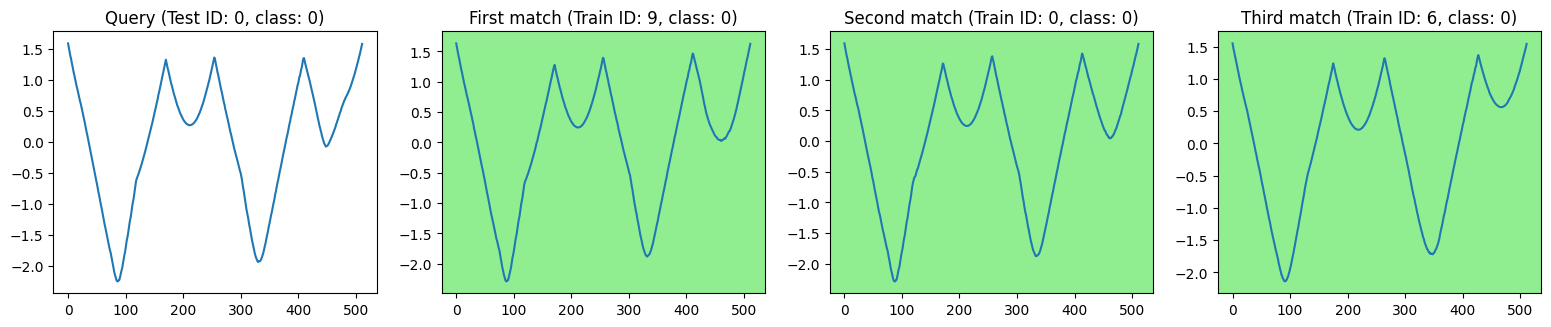

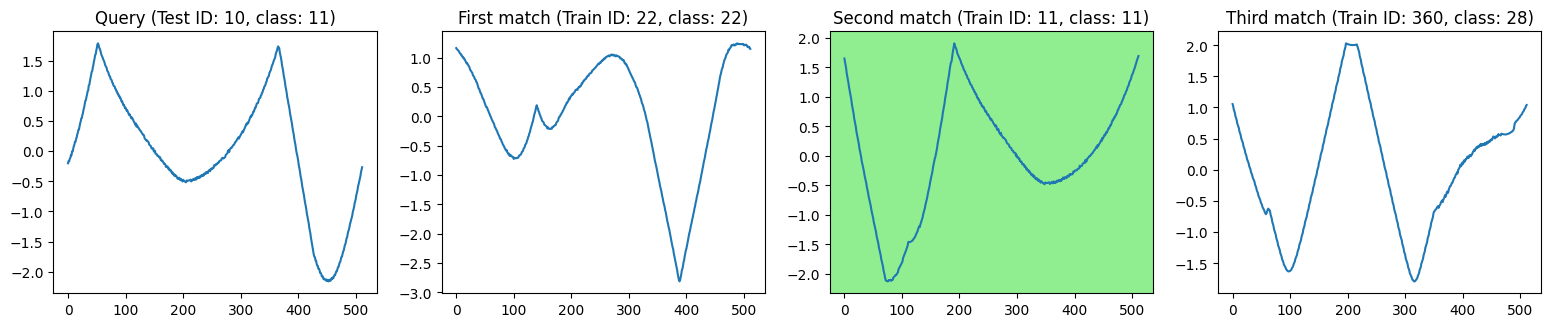

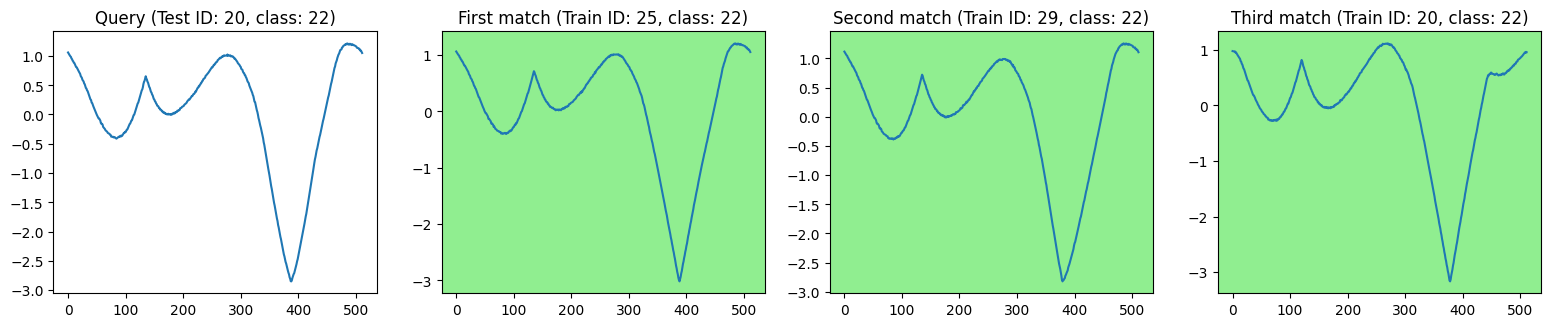

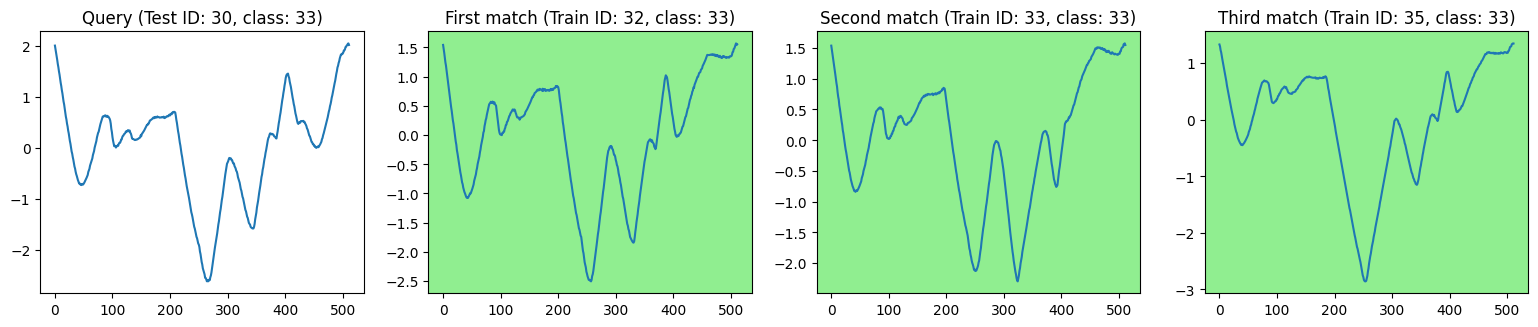

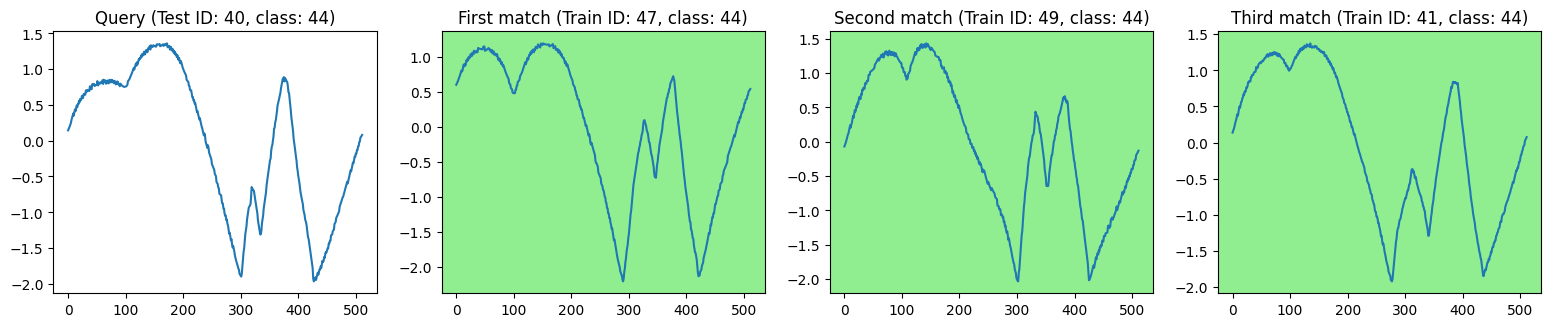

In [8]:
plotted_list = []
for sample_idx, sample in enumerate(test_dataset):
    if sample["target_values"] in plotted_list:
        continue
    elif len(plotted_list) >= 5:  # plot max five classes
        break
    else:
        plotted_list.append(sample["target_values"])

    first_match = I_all[sample_idx][0]
    second_match = I_all[sample_idx][1]
    third_match = I_all[sample_idx][2]

    label = test_dataset[sample_idx]["target_values"]
    first_label = train_dataset[first_match]["target_values"]
    second_label = train_dataset[second_match]["target_values"]
    third_label = train_dataset[third_match]["target_values"]

    fig, ax = plt.subplots(1, 4, figsize=(6.4 * 3, 3.4))
    ax[0].plot(test_dataset[sample_idx]["past_values"])
    ax[0].set_title(f"Query (Test ID: {sample_idx}, class: {label})")

    ax[1].plot(train_dataset[first_match]["past_values"])
    ax[1].set_title(f"First match (Train ID: {first_match}, class: {first_label})")
    ax[1].set_facecolor("lightgreen") if label == first_label else None

    ax[2].plot(train_dataset[second_match]["past_values"])
    ax[2].set_title(f"Second match (Train ID: {second_match}, class: {second_label})")
    ax[2].set_facecolor("lightgreen") if label == second_label else None

    ax[3].plot(train_dataset[third_match]["past_values"])
    ax[3].set_title(f"Third match (Train ID: {third_match}, class: {third_label})")
    ax[3].set_facecolor("lightgreen") if label == third_label else None